# 🧠 Review Insights & Sentiment Prediction

This project aims to extract strategic insights from customer reviews using Natural Language Processing (NLP).

We will classify sentiment into three categories:
- **Positive**
- **Neutral**
- **Negative**

Our methodology includes:
- Exploratory Data Analysis (EDA)
- Text preprocessing with spaCy
- Classical ML model (TF-IDF + Logistic Regression)
- Modern NLP model (DistilBERT from HuggingFace)
- Evaluation using classification metrics
- Strategic recommendations for product and marketing teams

## 📗 2. Importing Libraries

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# NLP and Transformers
import spacy
import torch
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification, DistilBertTokenizerFast
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score

# Display configuration
sns.set(style="whitegrid")

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 📂 3. Load and Preview the Dataset

We now load the Amazon product reviews dataset.  
This dataset contains over 28,000 reviews including star ratings and review text.

We'll preview the structure to identify relevant columns and assess data quality.

In [2]:
# Try loading the dataset (update the path if needed)
df = pd.read_csv('../data/raw_dataset.csv')

# Preview structure
df.head()

,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,...,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs
0,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,3,https://www.amazon.com/product-reviews/B00QWO9...,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,Byger yang,"https://www.barcodable.com/upc/841710106442,ht..."
1,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,4,https://www.amazon.com/product-reviews/B00QWO9...,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,ByMG,"https://www.barcodable.com/upc/841710106442,ht..."
2,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...,BySharon Lambert,"https://www.barcodable.com/upc/841710106442,ht..."
3,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Seem to work as well as name brand batteries a...,... as well as name brand batteries at a much ...,Bymark sexson,"https://www.barcodable.com/upc/841710106442,ht..."
4,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,These batteries are very long lasting the pric...,... batteries are very long lasting the price ...,Bylinda,"https://www.barcodable.com/upc/841710106442,ht..."


## 🧹 4. Data Cleaning and Sentiment Labeling (with Product Context)

In addition to the review text and rating, we will keep two important columns:

- `name`: the product name  
- `primaryCategories`: the product category  

These are **not used in the sentiment model**, but will be useful for business insights later (e.g., identifying which products or categories receive the most negative reviews).

We will also map the `rating` column into three sentiment classes:
- 1–2 stars → Negative
- 3 stars → Neutral
- 4–5 stars → Positive

In [3]:
# Keep relevant columns for modeling and insights
df = df[['name', 'primaryCategories', 'reviews.text', 'reviews.rating']].dropna()
df.columns = ['product_name', 'category', 'review', 'rating']  # Rename for clarity

# Map numerical rating to sentiment
def map_sentiment(rating):
    if rating <= 2:
        return 'negative'
    elif rating == 3:
        return 'neutral'
    else:
        return 'positive'

df['sentiment'] = df['rating'].apply(map_sentiment)

# Preview result
df.head()

,product_name,category,review,rating,sentiment
0,AmazonBasics AAA Performance Alkaline Batterie...,Health & Beauty,I order 3 of them and one of the item is bad q...,3,neutral
1,AmazonBasics AAA Performance Alkaline Batterie...,Health & Beauty,Bulk is always the less expensive way to go fo...,4,positive
2,AmazonBasics AAA Performance Alkaline Batterie...,Health & Beauty,Well they are not Duracell but for the price i...,5,positive
3,AmazonBasics AAA Performance Alkaline Batterie...,Health & Beauty,Seem to work as well as name brand batteries a...,5,positive
4,AmazonBasics AAA Performance Alkaline Batterie...,Health & Beauty,These batteries are very long lasting the pric...,5,positive


## 📘 5. Exploratory Data Analysis (EDA)

## 📊 5.1. Sentiment Class Distribution

We begin by examining how sentiment labels are distributed in the dataset.  
This is important to detect class imbalance, which can bias model training.

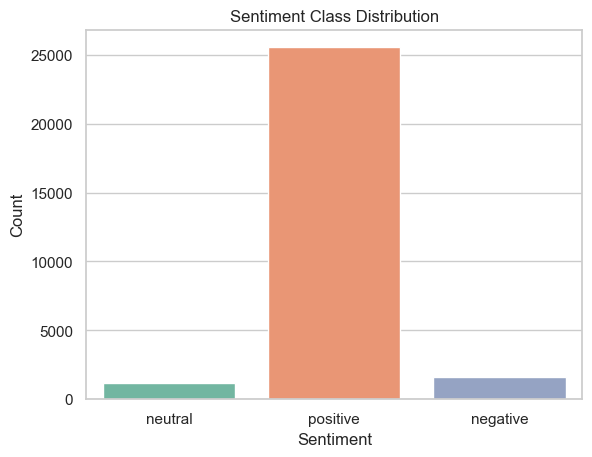

sentiment
positive    0.901631
negative    0.055803
neutral     0.042567
Name: proportion, dtype: float64

In [4]:
sns.countplot(x='sentiment', data=df, palette='Set2')
plt.title('Sentiment Class Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

# Show class proportions
df['sentiment'].value_counts(normalize=True)

### Observations on Sentiment Distribution

- The dataset is **highly imbalanced**.
- Over **89% of the reviews are labeled as "positive"**, while "neutral" and "negative" together make up less than 11%.
- This imbalance may cause **biased model predictions** favoring the majority class.

### ⚠️ Implications for Modeling

- Using only accuracy as an evaluation metric would be misleading.
- We must focus on **Precision, Recall, and F1-score** per class to get a reliable assessment.
- During modeling, we should consider:
  - Assigning **class weights** to handle imbalance.
  - Possibly exploring **undersampling**, **oversampling**, or **balanced sampling** if needed.
  - Evaluating different models with **macro-averaged metrics**.

This distribution reflects the typical behavior in consumer product reviews, where positive bias is common due to user satisfaction or selective review behavior.

## 🧹 5.2 Null Values Check

We check for missing values in key columns.  
This ensures data consistency and highlights potential quality issues.

In [5]:
# Check for nulls
df.isnull().sum()

product_name    0
category        0
review          0
rating          0
sentiment       0
dtype: int64

### Null Values Analysis

We verified that there are no missing values in the essential columns:

- `product_name`  
- `category`  
- `review`  
- `rating`  
- `sentiment` (derived)

This confirms that the dataset is structurally clean and ready for further preprocessing and modeling.

No imputation or filtering is required at this stage.

## 🔎 5.3 Outlier Detection in Review Length

We examine the length of each review to detect outliers.  
Extremely short or long reviews may carry limited or disproportionate weight.

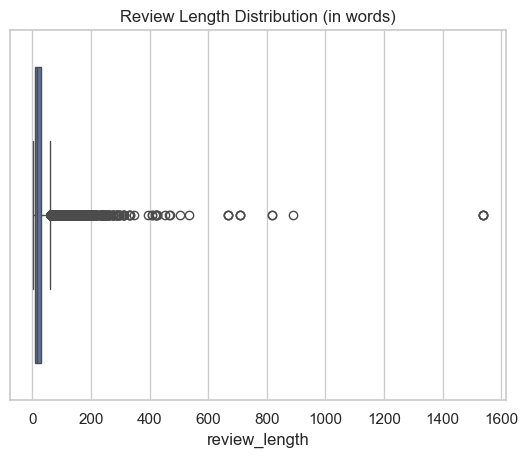

In [6]:
# Add a column for review length
df['review_length'] = df['review'].apply(lambda x: len(x.split()))

# Basic statistics
df['review_length'].describe()

# Boxplot for outlier detection
sns.boxplot(data=df, x='review_length')
plt.title('Review Length Distribution (in words)')
plt.show()

In [7]:
# Check review length distribution
df['review_length'].describe(percentiles=[0.25, 0.5, 0.75, 0.95, 0.99])

count    28332.000000
mean        25.945009
std         37.075899
min          1.000000
25%         10.000000
50%         17.000000
75%         31.000000
95%         75.000000
99%        147.000000
max       1539.000000
Name: review_length, dtype: float64

In [8]:
# Remove extreme outliers above 150 words (approx 99th percentile)
df = df[df['review_length'] <= 150]

### Review Length Outlier Analysis

- The 99th percentile of review length is 147 words.
- A small number of reviews exceed 500–1000 words, with the maximum at 1539.
- These are outliers that could distort model performance and increase computational cost.

✅ We chose to **filter reviews longer than 150 words**, removing the top 1% of extreme outliers.  
This keeps the dataset clean and ensures compatibility with TF-IDF and Transformer models.

## 📈 5.4 Histogram of Review Lengths

We plot the distribution of review lengths to understand common ranges.  
This can inform preprocessing decisions, such as padding and truncation for transformers.

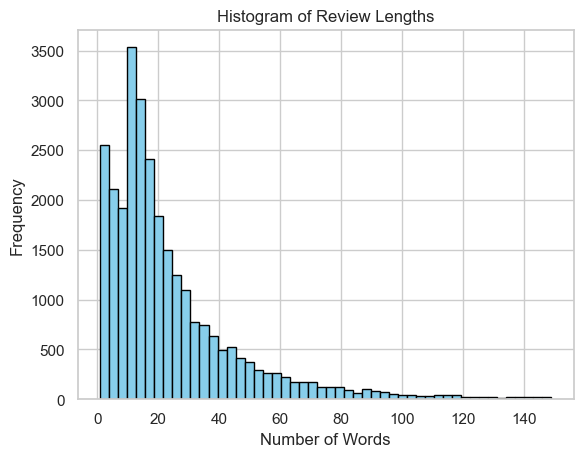

In [9]:
plt.hist(df['review_length'], bins=50, color='skyblue', edgecolor='black')
plt.title('Histogram of Review Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

### Histogram of Review Lengths

- Most customer reviews are short, typically under 40 words.
- The distribution is **right-skewed**, with a long tail of longer reviews.
- This validates our previous decision to filter reviews longer than 150 words.

The insights suggest:
- Padding requirements for deep learning models will be low.
- TF-IDF vectors will be sparse but manageable.
- We can expect relatively fast training times for classical models.

## 🏷️ 5.5 Top Product Categories by Review Volume

This analysis shows which product categories appear most frequently in the dataset.  
Although not used in the model directly, this information helps guide business insights.

Understanding the volume of reviews by category can:
- Reveal product lines with the most customer interaction
- Highlight areas where sentiment analysis might have the biggest impact
- Inform future dashboard or reporting priorities

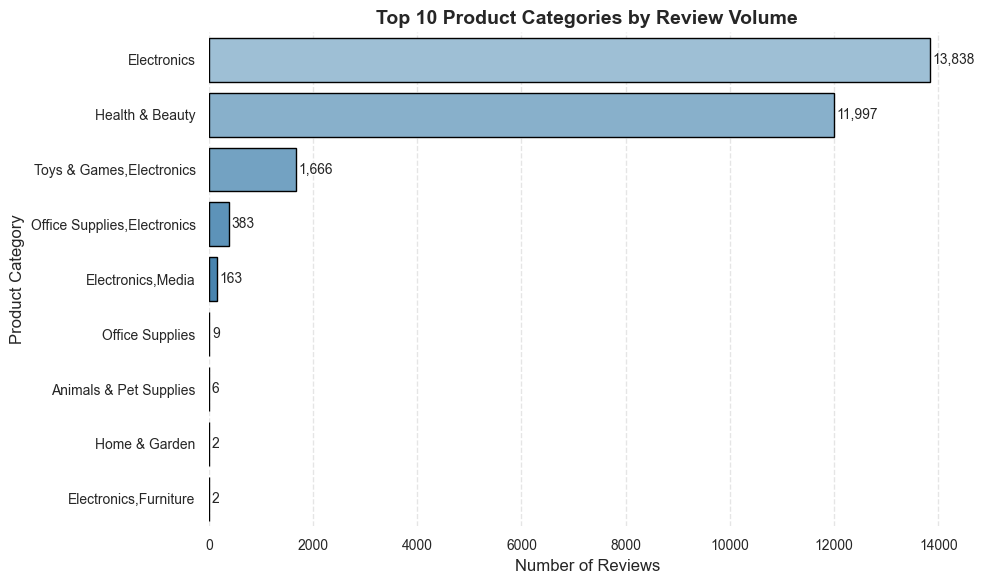

In [10]:
# Calculate top categories
top_categories = df['category'].value_counts().nlargest(10)

# Plot with improved style
plt.figure(figsize=(10, 6))
bars = sns.barplot(
    y=top_categories.index,
    x=top_categories.values,
    palette='Blues_d',
    edgecolor='black'
)

# Add value labels to each bar
for i, bar in enumerate(bars.patches):
    plt.text(
        bar.get_width() + 50,  # offset to the right
        bar.get_y() + bar.get_height() / 2,
        f'{int(bar.get_width()):,}',
        va='center',
        fontsize=10
    )

plt.title('Top 10 Product Categories by Review Volume', fontsize=14, weight='bold')
plt.xlabel('Number of Reviews', fontsize=12)
plt.ylabel('Product Category', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='x', linestyle='--', alpha=0.5)
sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.show()

### Top Product Categories by Review Volume

- The dataset is highly concentrated in two main categories:
  - **Electronics**
  - **Health & Beauty**

- These two categories account for the majority of customer interaction and will be key targets for downstream analysis.

- Some categories are **compound or mixed** (e.g. "Toys & Games, Electronics"), which might require cleaning if deeper segmentation is needed.

- Categories with fewer than 10 reviews may be considered noise for segmentation and could be grouped into an "Other" class in future reporting.

➡️ This insight allows future stakeholders (e.g. product managers, marketing teams) to focus sentiment analysis and resource allocation on high-impact product lines.

## 5.6 🧾 Summary of Exploratory Data Analysis (EDA)

We performed a comprehensive Exploratory Data Analysis to understand the structure, quality, and distribution of the dataset before building sentiment classification models.

### 1. Sentiment Class Distribution
- The dataset is **highly imbalanced**, with over **89% labeled as "positive"**.
- "Negative" and "neutral" classes are significantly underrepresented.
- This imbalance requires careful metric selection (Precision, Recall, F1) and possibly weighted models.

### 2. Null Value Analysis
- No missing values in key columns: `product_name`, `category`, `review`, `rating`, `sentiment`.
- The dataset is structurally clean and ready for preprocessing.

### 3. Review Length Analysis
- Most reviews are **short and concise**, with a median of **17 words**.
- A small number of reviews exceed **1500 words**, which are considered outliers.
- We removed reviews with more than **150 words** to improve stability and compatibility with NLP models (e.g. TF-IDF, BERT).

### 4. Text Length Distribution
- The histogram shows a **right-skewed** distribution with most reviews under **40 words**.
- This suggests low padding needs and fast training time for models.

### 5. Product Category Distribution
- The dataset is dominated by **Electronics** and **Health & Beauty**.
- These categories will provide the most insights from sentiment analysis.
- Compound categories were detected and could be cleaned or aggregated for clearer segmentation.

---

🧠 This EDA provides a solid understanding of the dataset and directly informs modeling decisions, preprocessing strategies, and business recommendations.

## 🧽 6. Text Preprocessing with spaCy

Text preprocessing is essential in NLP to reduce noise and prepare the input for modeling.

We use **spaCy** to:
- Convert text to lowercase
- Remove stopwords, punctuation, and non-alphabetic tokens
- Apply lemmatization to normalize words (e.g. "running" → "run")

This ensures better token consistency and reduces vocabulary sparsity.

In [11]:
from tqdm import tqdm

# Load spaCy English model
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

# Function to clean and lemmatize text
def spacy_cleaner(text):
    doc = nlp(text.lower())
    tokens = [
        token.lemma_
        for token in doc
        if token.is_alpha and not token.is_stop
    ]
    return " ".join(tokens)

# Apply preprocessing
tqdm.pandas()
df['clean_review'] = df['review'].progress_apply(spacy_cleaner)

# Preview result
df[['review', 'clean_review']].head()

100%|██████████| 28066/28066 [01:14<00:00, 379.02it/s]


,review,clean_review
0,I order 3 of them and one of the item is bad q...,order item bad quality miss backup spring pc a...
1,Bulk is always the less expensive way to go fo...,bulk expensive way product like
2,Well they are not Duracell but for the price i...,duracell price happy
3,Seem to work as well as name brand batteries a...,work brand battery well price
4,These batteries are very long lasting the pric...,battery long last price great


## 📘 7. Insights Before Modeling

## 🔤 7.1 Most Frequent Words by Sentiment

By analyzing word frequencies by sentiment class, we can identify:
- Common expressions of dissatisfaction in negative reviews
- Positive descriptors and promotional language
- Ambiguous or filler terms in neutral reviews

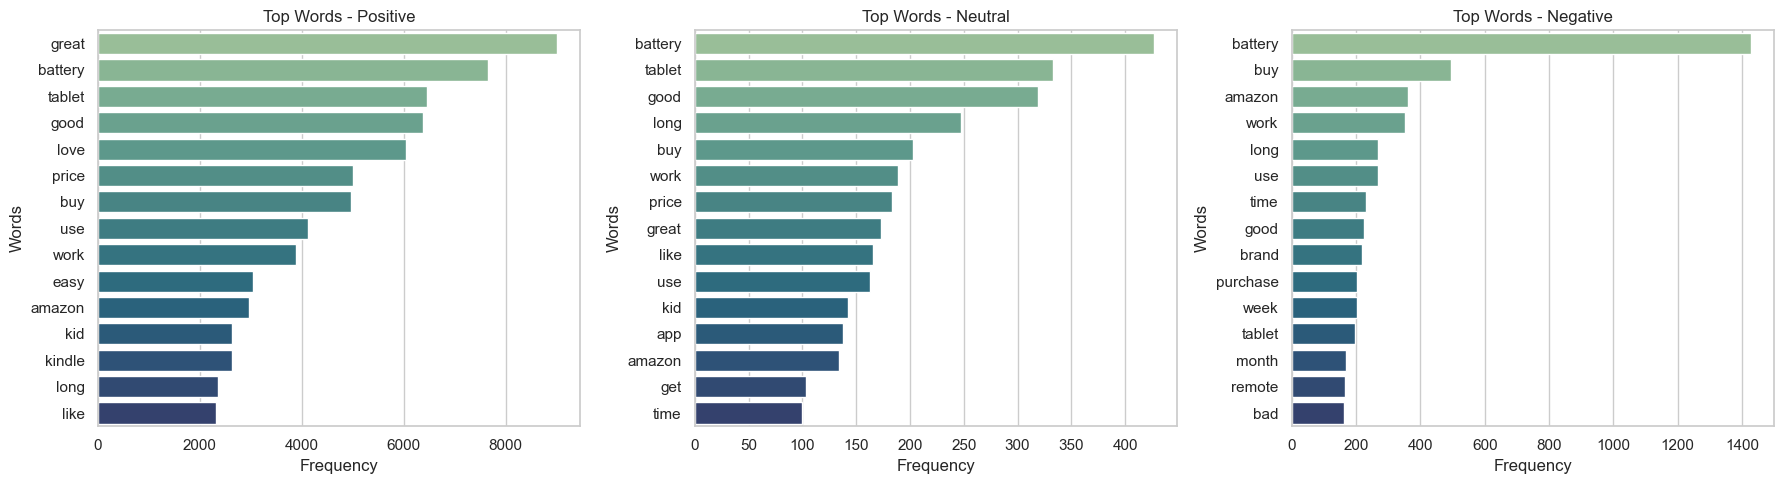

In [12]:
from collections import Counter

# Create a frequency dictionary per sentiment
def get_top_words(sentiment, n=15):
    words = " ".join(df[df['sentiment'] == sentiment]['clean_review']).split()
    return dict(Counter(words).most_common(n))

# Plot bar charts for each sentiment
plt.figure(figsize=(18, 5))
for i, sentiment in enumerate(['positive', 'neutral', 'negative']):
    plt.subplot(1, 3, i+1)
    top_words = get_top_words(sentiment)
    sns.barplot(x=list(top_words.values()), y=list(top_words.keys()), palette='crest')
    plt.title(f"Top Words - {sentiment.capitalize()}")
    plt.xlabel("Frequency")
    plt.ylabel("Words")

plt.tight_layout()
plt.show()

### 🔤 Word Frequency by Sentiment Class

By analyzing the top words used in each sentiment class, we uncover patterns that reflect how customers express satisfaction or frustration:

- **Positive reviews** focus on product quality and emotional appreciation, with keywords like _great_, _love_, _easy_, and _good_.
- **Neutral reviews** tend to repeat common product terms without emotional tone.
- **Negative reviews** include a mix of complaint indicators and product references, such as _battery_, _purchase_, _remote_, and _bad_.

These patterns suggest strong sentiment signals embedded in specific word choices. This helps validate the quality of our labeling and guides feature importance for modeling.

## ☁️ 7.2 Word Cloud per Sentiment Class

We generate word clouds for each sentiment category to visually summarize the most prominent words.

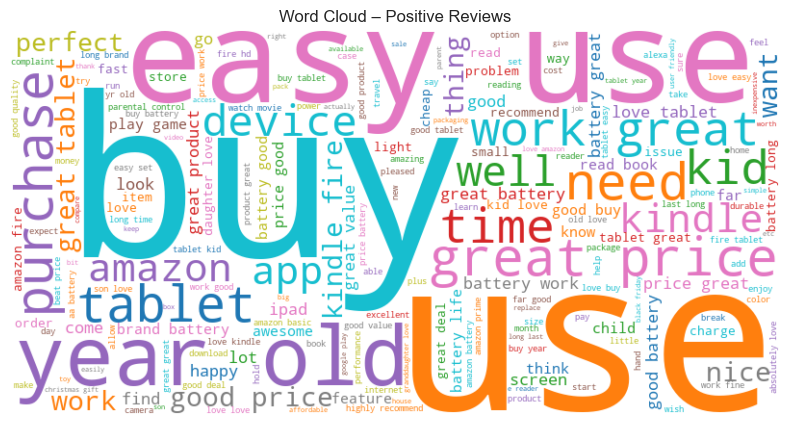

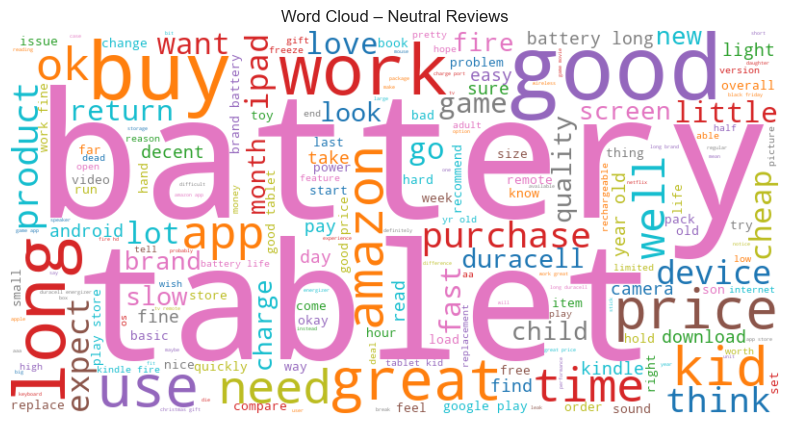

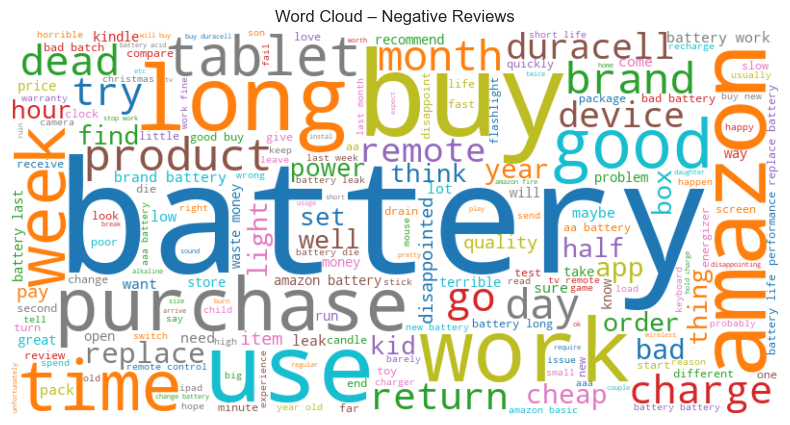

In [13]:
from wordcloud import WordCloud

for sentiment in ['positive', 'neutral', 'negative']:
    text = " ".join(df[df['sentiment'] == sentiment]['clean_review'])
    wc = WordCloud(width=800, height=400, background_color='white', colormap='tab10').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud – {sentiment.capitalize()} Reviews")
    plt.show()

### Word Clouds by Sentiment Class

We visualized the top keywords in each sentiment class using word clouds:

- **Positive reviews** show strong emphasis on ease of use, product quality, and satisfaction.
- **Neutral reviews** include shared vocabulary from both sides, indicating ambiguous or functional feedback.
- **Negative reviews** focus heavily on battery issues, product failures, and return experiences.

These insights confirm the relevance of our text preprocessing and the sentiment mapping logic.  
They also highlight the potential impact of NLP models on identifying weak points in customer experience.

## 📊 7.3 Sentiment Distribution per Product Category

This chart highlights which product categories receive more positive, negative or neutral reviews.
This can help businesses identify opportunities to improve specific product lines.

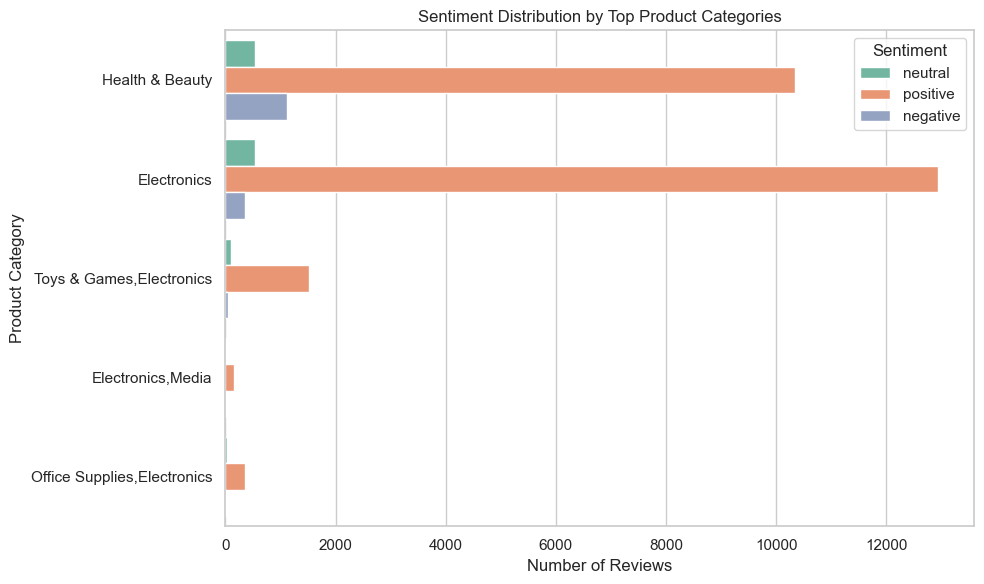

In [14]:
top_cat = df['category'].value_counts().nlargest(5).index
filtered = df[df['category'].isin(top_cat)]

plt.figure(figsize=(10, 6))
sns.countplot(data=filtered, y='category', hue='sentiment', palette='Set2')
plt.title("Sentiment Distribution by Top Product Categories")
plt.xlabel("Number of Reviews")
plt.ylabel("Product Category")
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

### Sentiment Distribution by Product Category

We analyzed how sentiment is distributed across the top 5 product categories:

- **Electronics** and **Health & Beauty** dominate both in review volume and in the number of positive reviews.
- However, **Health & Beauty** shows a **higher share of negative reviews** compared to Electronics.
- Categories like `Toys & Games, Electronics` remain overwhelmingly positive but should still be monitored for shifts in sentiment.

This kind of insight allows business teams to:
- Prioritize improvements in categories with higher dissatisfaction
- Align product strategy with sentiment patterns
- Justify deeper investigation into underperforming product lines

## 🤖 8. Baseline Model with TF-IDF and Logistic Regression

We now train a baseline sentiment classifier using a traditional NLP pipeline.

- **TF-IDF Vectorization** transforms the cleaned text into numerical feature vectors.
- **Logistic Regression** is used as a fast, interpretable baseline model.
- We evaluate performance using **Precision, Recall, F1-score**, and **Confusion Matrix**, given the class imbalance.

This serves as a benchmark to compare later with advanced transformer-based models.

              precision    recall  f1-score   support

    negative     0.5070    0.8252    0.6281       309
     neutral     0.2635    0.6582    0.3764       237
    positive     0.9834    0.8769    0.9271      5068

    accuracy                         0.8648      5614
   macro avg     0.5846    0.7868    0.6438      5614
weighted avg     0.9268    0.8648    0.8874      5614



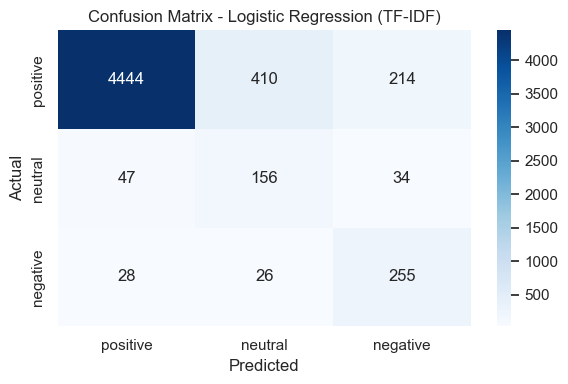

In [15]:
# 1. Split the dataset
X = df['clean_review']
y = df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 2. Build the pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1,2))),
    ('clf', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
])

# 3. Train the model
pipeline.fit(X_train, y_train)

# 4. Predict and evaluate
y_pred = pipeline.predict(X_test)

# Report
print(classification_report(y_test, y_pred, digits=4))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=['positive', 'neutral', 'negative'])

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['positive', 'neutral', 'negative'], yticklabels=['positive', 'neutral', 'negative'])
plt.title("Confusion Matrix - Logistic Regression (TF-IDF)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

### 📦 Baseline Model Evaluation: TF-IDF + Logistic Regression

**Global Accuracy**: 86.5%  
**Macro F1 Score**: 0.64  
**Weighted F1 Score**: 0.88  

- The model performs very well for the dominant class ("positive"), with an F1-score of 0.93.
- It struggles with minority classes, especially "neutral", which had poor precision (0.26).
- The confusion matrix shows frequent misclassification between neutral/positive and positive/negative.

🧠 These results are expected in imbalanced datasets and highlight the importance of weighted evaluation metrics.  
The model provides a solid benchmark to improve upon using more sophisticated architectures (e.g., BERT).

## 🔧 8.1 Hyperparameter Tuning with GridSearchCV (TF-IDF + Logistic Regression)

To improve our baseline model, we perform hyperparameter tuning using GridSearchCV.

We aim to optimize:
- `max_df`, `min_df`: control the inclusion of very frequent or rare terms
- `ngram_range`: use of unigrams or bigrams
- `C`: regularization strength for Logistic Regression
- `penalty`: type of penalty (`l2` or `elasticnet`)

Evaluation is based on **macro F1-score**, given the class imbalance.

In [16]:
from sklearn.exceptions import ConvergenceWarning

# Suppress common warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Define pipeline
pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(class_weight='balanced', solver='saga', max_iter=1000, random_state=42))
])

# Define parameter grid
param_grid = {
    'tfidf__max_df': [0.75, 0.9],
    'tfidf__min_df': [3, 5],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'clf__C': [0.1, 1, 5],
    'clf__penalty': ['l2', 'elasticnet'],
    'clf__l1_ratio': [0.0, 0.5]  # Only relevant for 'elasticnet'
}

# Setup GridSearchCV
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=3,
    scoring='f1_macro',
    verbose=2,
    n_jobs=-1
)

# Fit with warning suppression context
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    grid.fit(X_train, y_train)

# Print best params and performance
print("🔍 Best Parameters:", grid.best_params_)

# Predict and evaluate on test set
y_pred = grid.predict(X_test)
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred, digits=4))

Fitting 3 folds for each of 96 candidates, totalling 288 fits


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python

[CV] END clf__C=0.1, clf__l1_ratio=0.0, clf__penalty=l2, tfidf__max_df=0.75, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time=   3.2s
[CV] END clf__C=0.1, clf__l1_ratio=0.0, clf__penalty=l2, tfidf__max_df=0.75, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time=   3.2s
[CV] END clf__C=0.1, clf__l1_ratio=0.0, clf__penalty=l2, tfidf__max_df=0.75, tfidf__min_df=3, tfidf__ngram_range=(1, 1); total time=   3.3s
[CV] END clf__C=0.1, clf__l1_ratio=0.0, clf__penalty=l2, tfidf__max_df=0.75, tfidf__min_df=3, tfidf__ngram_range=(1, 1); total time=   3.3s
[CV] END clf__C=0.1, clf__l1_ratio=0.0, clf__penalty=l2, tfidf__max_df=0.75, tfidf__min_df=3, tfidf__ngram_range=(1, 1); total time=   3.4s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python

[CV] END clf__C=0.1, clf__l1_ratio=0.0, clf__penalty=l2, tfidf__max_df=0.75, tfidf__min_df=3, tfidf__ngram_range=(1, 2); total time=   4.9s
[CV] END clf__C=0.1, clf__l1_ratio=0.0, clf__penalty=l2, tfidf__max_df=0.75, tfidf__min_df=3, tfidf__ngram_range=(1, 2); total time=   4.9s
[CV] END clf__C=0.1, clf__l1_ratio=0.0, clf__penalty=l2, tfidf__max_df=0.75, tfidf__min_df=3, tfidf__ngram_range=(1, 2); total time=   4.9s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python

[CV] END clf__C=0.1, clf__l1_ratio=0.0, clf__penalty=l2, tfidf__max_df=0.75, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time=   3.3s
[CV] END clf__C=0.1, clf__l1_ratio=0.0, clf__penalty=l2, tfidf__max_df=0.9, tfidf__min_df=3, tfidf__ngram_range=(1, 1); total time=   3.3s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-pack

[CV] END clf__C=0.1, clf__l1_ratio=0.0, clf__penalty=l2, tfidf__max_df=0.75, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time=   4.2s
[CV] END clf__C=0.1, clf__l1_ratio=0.0, clf__penalty=l2, tfidf__max_df=0.75, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time=   4.3s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END clf__C=0.1, clf__l1_ratio=0.0, clf__penalty=l2, tfidf__max_df=0.75, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time=   4.5s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=0.1, clf__l1_ratio=0.0, clf__penalty=l2, tfidf__max_df=0.9, tfidf__min_df=3, tfidf__ngram_range=(1, 1); total time=   3.2s
[CV] END clf__C=0.1, clf__l1_ratio=0.0, clf__penalty=l2, tfidf__max_df=0.9, tfidf__min_df=3, tfidf__ngram_range=(1, 1); total time=   3.4s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-pack

[CV] END clf__C=0.1, clf__l1_ratio=0.0, clf__penalty=l2, tfidf__max_df=0.9, tfidf__min_df=3, tfidf__ngram_range=(1, 2); total time=   5.0s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=0.1, clf__l1_ratio=0.0, clf__penalty=l2, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time=   3.2s
[CV] END clf__C=0.1, clf__l1_ratio=0.0, clf__penalty=l2, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time=   3.3s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=0.1, clf__l1_ratio=0.0, clf__penalty=l2, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time=   3.2s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=0.1, clf__l1_ratio=0.0, clf__penalty=l2, tfidf__max_df=0.9, tfidf__min_df=3, tfidf__ngram_range=(1, 2); total time=   4.9s
[CV] END clf__C=0.1, clf__l1_ratio=0.0, clf__penalty=l2, tfidf__max_df=0.9, tfidf__min_df=3, tfidf__ngram_range=(1, 2); total time=   5.0s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=0.1, clf__l1_ratio=0.0, clf__penalty=l2, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time=   4.7s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=0.1, clf__l1_ratio=0.0, clf__penalty=l2, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time=   4.8s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=0.1, clf__l1_ratio=0.0, clf__penalty=elasticnet, tfidf__max_df=0.75, tfidf__min_df=3, tfidf__ngram_range=(1, 1); total time=   3.4s
[CV] END clf__C=0.1, clf__l1_ratio=0.0, clf__penalty=elasticnet, tfidf__max_df=0.75, tfidf__min_df=3, tfidf__ngram_range=(1, 1); total time=   3.4s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=0.1, clf__l1_ratio=0.0, clf__penalty=elasticnet, tfidf__max_df=0.75, tfidf__min_df=3, tfidf__ngram_range=(1, 1); total time=   3.5s
[CV] END clf__C=0.1, clf__l1_ratio=0.0, clf__penalty=l2, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time=   4.6s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=0.1, clf__l1_ratio=0.0, clf__penalty=elasticnet, tfidf__max_df=0.75, tfidf__min_df=3, tfidf__ngram_range=(1, 2); total time=   5.1s
[CV] END clf__C=0.1, clf__l1_ratio=0.0, clf__penalty=elasticnet, tfidf__max_df=0.75, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time=   3.5s
[CV] END clf__C=0.1, clf__l1_ratio=0.0, clf__penalty=elasticnet, tfidf__max_df=0.75, tfidf__min_df=3, tfidf__ngram_range=(1, 2); total time=   5.1s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=0.1, clf__l1_ratio=0.0, clf__penalty=elasticnet, tfidf__max_df=0.75, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time=   3.4s
[CV] END clf__C=0.1, clf__l1_ratio=0.0, clf__penalty=elasticnet, tfidf__max_df=0.75, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time=   3.3s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=0.1, clf__l1_ratio=0.0, clf__penalty=elasticnet, tfidf__max_df=0.75, tfidf__min_df=3, tfidf__ngram_range=(1, 2); total time=   5.0s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=0.1, clf__l1_ratio=0.0, clf__penalty=elasticnet, tfidf__max_df=0.75, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time=   4.4s
[CV] END clf__C=0.1, clf__l1_ratio=0.0, clf__penalty=elasticnet, tfidf__max_df=0.75, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time=   4.5s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=0.1, clf__l1_ratio=0.0, clf__penalty=elasticnet, tfidf__max_df=0.9, tfidf__min_df=3, tfidf__ngram_range=(1, 1); total time=   3.2s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=0.1, clf__l1_ratio=0.0, clf__penalty=elasticnet, tfidf__max_df=0.9, tfidf__min_df=3, tfidf__ngram_range=(1, 1); total time=   3.3s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=0.1, clf__l1_ratio=0.0, clf__penalty=elasticnet, tfidf__max_df=0.9, tfidf__min_df=3, tfidf__ngram_range=(1, 1); total time=   3.2s
[CV] END clf__C=0.1, clf__l1_ratio=0.0, clf__penalty=elasticnet, tfidf__max_df=0.75, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time=   4.4s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=0.1, clf__l1_ratio=0.0, clf__penalty=elasticnet, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time=   3.6s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=0.1, clf__l1_ratio=0.0, clf__penalty=elasticnet, tfidf__max_df=0.9, tfidf__min_df=3, tfidf__ngram_range=(1, 2); total time=   5.4s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END clf__C=0.1, clf__l1_ratio=0.0, clf__penalty=elasticnet, tfidf__max_df=0.9, tfidf__min_df=3, tfidf__ngram_range=(1, 2); total time=   5.3s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=0.1, clf__l1_ratio=0.0, clf__penalty=elasticnet, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time=   3.5s
[CV] END clf__C=0.1, clf__l1_ratio=0.0, clf__penalty=elasticnet, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time=   3.8s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=0.1, clf__l1_ratio=0.0, clf__penalty=elasticnet, tfidf__max_df=0.9, tfidf__min_df=3, tfidf__ngram_range=(1, 2); total time=   5.2s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=0.1, clf__l1_ratio=0.0, clf__penalty=elasticnet, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time=   5.0s
[CV] END clf__C=0.1, clf__l1_ratio=0.0, clf__penalty=elasticnet, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time=   4.9s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=0.1, clf__l1_ratio=0.5, clf__penalty=l2, tfidf__max_df=0.75, tfidf__min_df=3, tfidf__ngram_range=(1, 1); total time=   3.6s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=0.1, clf__l1_ratio=0.5, clf__penalty=l2, tfidf__max_df=0.75, tfidf__min_df=3, tfidf__ngram_range=(1, 1); total time=   3.7s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=0.1, clf__l1_ratio=0.5, clf__penalty=l2, tfidf__max_df=0.75, tfidf__min_df=3, tfidf__ngram_range=(1, 1); total time=   3.7s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=0.1, clf__l1_ratio=0.0, clf__penalty=elasticnet, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time=   5.0s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=0.1, clf__l1_ratio=0.5, clf__penalty=l2, tfidf__max_df=0.75, tfidf__min_df=3, tfidf__ngram_range=(1, 2); total time=   5.5s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/l

[CV] END clf__C=0.1, clf__l1_ratio=0.5, clf__penalty=l2, tfidf__max_df=0.75, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time=   3.5s
[CV] END clf__C=0.1, clf__l1_ratio=0.5, clf__penalty=l2, tfidf__max_df=0.75, tfidf__min_df=3, tfidf__ngram_range=(1, 2); total time=   5.3s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END clf__C=0.1, clf__l1_ratio=0.5, clf__penalty=l2, tfidf__max_df=0.75, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time=   3.4s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=0.1, clf__l1_ratio=0.5, clf__penalty=l2, tfidf__max_df=0.75, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time=   3.3s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=0.1, clf__l1_ratio=0.5, clf__penalty=l2, tfidf__max_df=0.75, tfidf__min_df=3, tfidf__ngram_range=(1, 2); total time=   5.2s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=0.1, clf__l1_ratio=0.5, clf__penalty=l2, tfidf__max_df=0.75, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time=   4.7s
[CV] END clf__C=0.1, clf__l1_ratio=0.5, clf__penalty=l2, tfidf__max_df=0.75, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time=   4.3s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-pack

[CV] END clf__C=0.1, clf__l1_ratio=0.5, clf__penalty=l2, tfidf__max_df=0.9, tfidf__min_df=3, tfidf__ngram_range=(1, 1); total time=   3.3s
[CV] END clf__C=0.1, clf__l1_ratio=0.5, clf__penalty=l2, tfidf__max_df=0.9, tfidf__min_df=3, tfidf__ngram_range=(1, 1); total time=   3.4s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=0.1, clf__l1_ratio=0.5, clf__penalty=l2, tfidf__max_df=0.9, tfidf__min_df=3, tfidf__ngram_range=(1, 1); total time=   3.3s
[CV] END clf__C=0.1, clf__l1_ratio=0.5, clf__penalty=l2, tfidf__max_df=0.75, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time=   4.4s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-pack

[CV] END clf__C=0.1, clf__l1_ratio=0.5, clf__penalty=l2, tfidf__max_df=0.9, tfidf__min_df=3, tfidf__ngram_range=(1, 2); total time=   5.2s
[CV] END clf__C=0.1, clf__l1_ratio=0.5, clf__penalty=l2, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time=   3.5s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=0.1, clf__l1_ratio=0.5, clf__penalty=l2, tfidf__max_df=0.9, tfidf__min_df=3, tfidf__ngram_range=(1, 2); total time=   5.3s
[CV] END clf__C=0.1, clf__l1_ratio=0.5, clf__penalty=l2, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time=   3.6s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=0.1, clf__l1_ratio=0.5, clf__penalty=l2, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time=   3.8s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=0.1, clf__l1_ratio=0.5, clf__penalty=l2, tfidf__max_df=0.9, tfidf__min_df=3, tfidf__ngram_range=(1, 2); total time=   5.6s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=0.1, clf__l1_ratio=0.5, clf__penalty=l2, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time=   5.0s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=0.1, clf__l1_ratio=0.5, clf__penalty=l2, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time=   5.3s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=0.1, clf__l1_ratio=0.5, clf__penalty=l2, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time=   4.8s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=0.1, clf__l1_ratio=0.5, clf__penalty=elasticnet, tfidf__max_df=0.75, tfidf__min_df=3, tfidf__ngram_range=(1, 1); total time= 1.3min


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=0.1, clf__l1_ratio=0.5, clf__penalty=elasticnet, tfidf__max_df=0.75, tfidf__min_df=3, tfidf__ngram_range=(1, 1); total time= 1.3min


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=0.1, clf__l1_ratio=0.5, clf__penalty=elasticnet, tfidf__max_df=0.75, tfidf__min_df=3, tfidf__ngram_range=(1, 1); total time= 1.3min


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=0.1, clf__l1_ratio=0.5, clf__penalty=elasticnet, tfidf__max_df=0.75, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time= 1.3min


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=0.1, clf__l1_ratio=0.5, clf__penalty=elasticnet, tfidf__max_df=0.75, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time= 1.3min


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=0.1, clf__l1_ratio=0.5, clf__penalty=elasticnet, tfidf__max_df=0.75, tfidf__min_df=3, tfidf__ngram_range=(1, 2); total time= 1.4min


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=0.1, clf__l1_ratio=0.5, clf__penalty=elasticnet, tfidf__max_df=0.75, tfidf__min_df=3, tfidf__ngram_range=(1, 2); total time= 1.4min


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=0.1, clf__l1_ratio=0.5, clf__penalty=elasticnet, tfidf__max_df=0.75, tfidf__min_df=3, tfidf__ngram_range=(1, 2); total time= 1.4min


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=0.1, clf__l1_ratio=0.5, clf__penalty=elasticnet, tfidf__max_df=0.75, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time= 1.2min


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=0.1, clf__l1_ratio=0.5, clf__penalty=elasticnet, tfidf__max_df=0.75, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time= 1.2min
[CV] END clf__C=0.1, clf__l1_ratio=0.5, clf__penalty=elasticnet, tfidf__max_df=0.9, tfidf__min_df=3, tfidf__ngram_range=(1, 2); total time= 1.2min


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=0.1, clf__l1_ratio=0.5, clf__penalty=elasticnet, tfidf__max_df=0.9, tfidf__min_df=3, tfidf__ngram_range=(1, 1); total time= 1.3min


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=0.1, clf__l1_ratio=0.5, clf__penalty=elasticnet, tfidf__max_df=0.9, tfidf__min_df=3, tfidf__ngram_range=(1, 1); total time= 1.2min


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=0.1, clf__l1_ratio=0.5, clf__penalty=elasticnet, tfidf__max_df=0.9, tfidf__min_df=3, tfidf__ngram_range=(1, 1); total time= 1.3min


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=0.1, clf__l1_ratio=0.5, clf__penalty=elasticnet, tfidf__max_df=0.75, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time= 1.4min
[CV] END clf__C=0.1, clf__l1_ratio=0.5, clf__penalty=elasticnet, tfidf__max_df=0.75, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time= 1.4min


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END clf__C=0.1, clf__l1_ratio=0.5, clf__penalty=elasticnet, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time= 1.2min


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END clf__C=0.1, clf__l1_ratio=0.5, clf__penalty=elasticnet, tfidf__max_df=0.9, tfidf__min_df=3, tfidf__ngram_range=(1, 2); total time= 1.3min


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=0.1, clf__l1_ratio=0.5, clf__penalty=elasticnet, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time= 1.2min


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=0.1, clf__l1_ratio=0.5, clf__penalty=elasticnet, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time= 1.2min


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=1, clf__l1_ratio=0.0, clf__penalty=l2, tfidf__max_df=0.75, tfidf__min_df=3, tfidf__ngram_range=(1, 1); total time=   2.9s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=0.1, clf__l1_ratio=0.5, clf__penalty=elasticnet, tfidf__max_df=0.9, tfidf__min_df=3, tfidf__ngram_range=(1, 2); total time= 1.3min


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END clf__C=1, clf__l1_ratio=0.0, clf__penalty=l2, tfidf__max_df=0.75, tfidf__min_df=3, tfidf__ngram_range=(1, 1); total time=   3.2s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END clf__C=1, clf__l1_ratio=0.0, clf__penalty=l2, tfidf__max_df=0.75, tfidf__min_df=3, tfidf__ngram_range=(1, 1); total time=   3.1s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=1, clf__l1_ratio=0.0, clf__penalty=l2, tfidf__max_df=0.75, tfidf__min_df=3, tfidf__ngram_range=(1, 2); total time=   4.6s
[CV] END clf__C=1, clf__l1_ratio=0.0, clf__penalty=l2, tfidf__max_df=0.75, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time=   3.1s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=1, clf__l1_ratio=0.0, clf__penalty=l2, tfidf__max_df=0.75, tfidf__min_df=3, tfidf__ngram_range=(1, 2); total time=   4.6s
[CV] END clf__C=1, clf__l1_ratio=0.0, clf__penalty=l2, tfidf__max_df=0.75, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time=   2.9s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-pack

[CV] END clf__C=1, clf__l1_ratio=0.0, clf__penalty=l2, tfidf__max_df=0.75, tfidf__min_df=3, tfidf__ngram_range=(1, 2); total time=   4.7s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END clf__C=1, clf__l1_ratio=0.0, clf__penalty=l2, tfidf__max_df=0.75, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time=   2.9s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=1, clf__l1_ratio=0.0, clf__penalty=l2, tfidf__max_df=0.75, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time=   4.2s
[CV] END clf__C=1, clf__l1_ratio=0.0, clf__penalty=l2, tfidf__max_df=0.9, tfidf__min_df=3, tfidf__ngram_range=(1, 1); total time=   2.9s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=1, clf__l1_ratio=0.0, clf__penalty=l2, tfidf__max_df=0.75, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time=   4.0s
[CV] END clf__C=1, clf__l1_ratio=0.0, clf__penalty=l2, tfidf__max_df=0.75, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time=   4.0s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-pack

[CV] END clf__C=0.1, clf__l1_ratio=0.5, clf__penalty=elasticnet, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time= 1.4min


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=1, clf__l1_ratio=0.0, clf__penalty=l2, tfidf__max_df=0.9, tfidf__min_df=3, tfidf__ngram_range=(1, 1); total time=   3.1s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END clf__C=1, clf__l1_ratio=0.0, clf__penalty=l2, tfidf__max_df=0.9, tfidf__min_df=3, tfidf__ngram_range=(1, 1); total time=   3.0s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=0.1, clf__l1_ratio=0.5, clf__penalty=elasticnet, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time= 1.3min
[CV] END clf__C=1, clf__l1_ratio=0.0, clf__penalty=l2, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time=   2.9s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-pack

[CV] END clf__C=1, clf__l1_ratio=0.0, clf__penalty=l2, tfidf__max_df=0.9, tfidf__min_df=3, tfidf__ngram_range=(1, 2); total time=   4.6s
[CV] END clf__C=1, clf__l1_ratio=0.0, clf__penalty=l2, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time=   3.0s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=1, clf__l1_ratio=0.0, clf__penalty=l2, tfidf__max_df=0.9, tfidf__min_df=3, tfidf__ngram_range=(1, 2); total time=   4.7s
[CV] END clf__C=1, clf__l1_ratio=0.0, clf__penalty=l2, tfidf__max_df=0.9, tfidf__min_df=3, tfidf__ngram_range=(1, 2); total time=   4.7s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=0.1, clf__l1_ratio=0.5, clf__penalty=elasticnet, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time= 1.4min


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=1, clf__l1_ratio=0.0, clf__penalty=l2, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time=   3.1s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=1, clf__l1_ratio=0.0, clf__penalty=elasticnet, tfidf__max_df=0.75, tfidf__min_df=3, tfidf__ngram_range=(1, 1); total time=   3.2s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=1, clf__l1_ratio=0.0, clf__penalty=elasticnet, tfidf__max_df=0.75, tfidf__min_df=3, tfidf__ngram_range=(1, 1); total time=   3.2s
[CV] END clf__C=1, clf__l1_ratio=0.0, clf__penalty=l2, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time=   4.3s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=1, clf__l1_ratio=0.0, clf__penalty=elasticnet, tfidf__max_df=0.75, tfidf__min_df=3, tfidf__ngram_range=(1, 1); total time=   3.3s
[CV] END clf__C=1, clf__l1_ratio=0.0, clf__penalty=l2, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time=   4.5s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=1, clf__l1_ratio=0.0, clf__penalty=l2, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time=   4.3s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=1, clf__l1_ratio=0.0, clf__penalty=elasticnet, tfidf__max_df=0.75, tfidf__min_df=3, tfidf__ngram_range=(1, 2); total time=   5.0s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=1, clf__l1_ratio=0.0, clf__penalty=elasticnet, tfidf__max_df=0.75, tfidf__min_df=3, tfidf__ngram_range=(1, 2); total time=   4.8s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=1, clf__l1_ratio=0.0, clf__penalty=elasticnet, tfidf__max_df=0.75, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time=   3.0s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=1, clf__l1_ratio=0.0, clf__penalty=elasticnet, tfidf__max_df=0.75, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time=   3.2s
[CV] END clf__C=1, clf__l1_ratio=0.0, clf__penalty=elasticnet, tfidf__max_df=0.75, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time=   3.0s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=1, clf__l1_ratio=0.0, clf__penalty=elasticnet, tfidf__max_df=0.75, tfidf__min_df=3, tfidf__ngram_range=(1, 2); total time=   4.7s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=1, clf__l1_ratio=0.0, clf__penalty=elasticnet, tfidf__max_df=0.75, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time=   4.2s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=1, clf__l1_ratio=0.0, clf__penalty=elasticnet, tfidf__max_df=0.75, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time=   4.1s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=1, clf__l1_ratio=0.0, clf__penalty=elasticnet, tfidf__max_df=0.9, tfidf__min_df=3, tfidf__ngram_range=(1, 1); total time=   3.0s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=1, clf__l1_ratio=0.0, clf__penalty=elasticnet, tfidf__max_df=0.9, tfidf__min_df=3, tfidf__ngram_range=(1, 1); total time=   3.2s
[CV] END clf__C=1, clf__l1_ratio=0.0, clf__penalty=elasticnet, tfidf__max_df=0.75, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time=   4.2s
[CV] END clf__C=1, clf__l1_ratio=0.0, clf__penalty=elasticnet, tfidf__max_df=0.9, tfidf__min_df=3, tfidf__ngram_range=(1, 1); total time=   3.1s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=1, clf__l1_ratio=0.0, clf__penalty=elasticnet, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time=   3.0s
[CV] END clf__C=1, clf__l1_ratio=0.0, clf__penalty=elasticnet, tfidf__max_df=0.9, tfidf__min_df=3, tfidf__ngram_range=(1, 2); total time=   4.5s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END clf__C=1, clf__l1_ratio=0.0, clf__penalty=elasticnet, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time=   3.1s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END clf__C=1, clf__l1_ratio=0.0, clf__penalty=elasticnet, tfidf__max_df=0.9, tfidf__min_df=3, tfidf__ngram_range=(1, 2); total time=   4.6s
[CV] END clf__C=1, clf__l1_ratio=0.0, clf__penalty=elasticnet, tfidf__max_df=0.9, tfidf__min_df=3, tfidf__ngram_range=(1, 2); total time=   4.9s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END clf__C=1, clf__l1_ratio=0.0, clf__penalty=elasticnet, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time=   3.1s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=1, clf__l1_ratio=0.0, clf__penalty=elasticnet, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time=   4.2s
[CV] END clf__C=1, clf__l1_ratio=0.0, clf__penalty=elasticnet, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time=   4.3s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=1, clf__l1_ratio=0.5, clf__penalty=l2, tfidf__max_df=0.75, tfidf__min_df=3, tfidf__ngram_range=(1, 1); total time=   3.0s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/l

[CV] END clf__C=1, clf__l1_ratio=0.5, clf__penalty=l2, tfidf__max_df=0.75, tfidf__min_df=3, tfidf__ngram_range=(1, 1); total time=   3.1s
[CV] END clf__C=1, clf__l1_ratio=0.0, clf__penalty=elasticnet, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time=   4.1s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END clf__C=1, clf__l1_ratio=0.5, clf__penalty=l2, tfidf__max_df=0.75, tfidf__min_df=3, tfidf__ngram_range=(1, 1); total time=   3.0s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=1, clf__l1_ratio=0.5, clf__penalty=l2, tfidf__max_df=0.75, tfidf__min_df=3, tfidf__ngram_range=(1, 2); total time=   4.6s
[CV] END clf__C=1, clf__l1_ratio=0.5, clf__penalty=l2, tfidf__max_df=0.75, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time=   3.2s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/l

[CV] END clf__C=1, clf__l1_ratio=0.5, clf__penalty=l2, tfidf__max_df=0.75, tfidf__min_df=3, tfidf__ngram_range=(1, 2); total time=   4.7s
[CV] END clf__C=1, clf__l1_ratio=0.5, clf__penalty=l2, tfidf__max_df=0.75, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time=   3.1s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-pack

[CV] END clf__C=1, clf__l1_ratio=0.5, clf__penalty=l2, tfidf__max_df=0.75, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time=   3.1s
[CV] END clf__C=1, clf__l1_ratio=0.5, clf__penalty=l2, tfidf__max_df=0.75, tfidf__min_df=3, tfidf__ngram_range=(1, 2); total time=   4.6s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-pack

[CV] END clf__C=1, clf__l1_ratio=0.5, clf__penalty=l2, tfidf__max_df=0.75, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time=   3.9s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END clf__C=1, clf__l1_ratio=0.5, clf__penalty=l2, tfidf__max_df=0.75, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time=   4.3s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END clf__C=1, clf__l1_ratio=0.5, clf__penalty=l2, tfidf__max_df=0.9, tfidf__min_df=3, tfidf__ngram_range=(1, 1); total time=   3.0s
[CV] END clf__C=1, clf__l1_ratio=0.5, clf__penalty=l2, tfidf__max_df=0.9, tfidf__min_df=3, tfidf__ngram_range=(1, 1); total time=   2.9s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END clf__C=1, clf__l1_ratio=0.5, clf__penalty=l2, tfidf__max_df=0.9, tfidf__min_df=3, tfidf__ngram_range=(1, 1); total time=   3.0s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=1, clf__l1_ratio=0.5, clf__penalty=l2, tfidf__max_df=0.75, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time=   3.9s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=1, clf__l1_ratio=0.5, clf__penalty=l2, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time=   3.0s
[CV] END clf__C=1, clf__l1_ratio=0.5, clf__penalty=l2, tfidf__max_df=0.9, tfidf__min_df=3, tfidf__ngram_range=(1, 2); total time=   4.5s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=1, clf__l1_ratio=0.5, clf__penalty=l2, tfidf__max_df=0.9, tfidf__min_df=3, tfidf__ngram_range=(1, 2); total time=   4.5s
[CV] END clf__C=1, clf__l1_ratio=0.5, clf__penalty=l2, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time=   3.0s
[CV] END clf__C=1, clf__l1_ratio=0.5, clf__penalty=l2, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time=   2.9s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=1, clf__l1_ratio=0.5, clf__penalty=l2, tfidf__max_df=0.9, tfidf__min_df=3, tfidf__ngram_range=(1, 2); total time=   4.6s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=1, clf__l1_ratio=0.5, clf__penalty=l2, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time=   4.0s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=1, clf__l1_ratio=0.5, clf__penalty=l2, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time=   4.1s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=1, clf__l1_ratio=0.5, clf__penalty=l2, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time=   3.9s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=1, clf__l1_ratio=0.5, clf__penalty=elasticnet, tfidf__max_df=0.75, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time= 6.1min


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=1, clf__l1_ratio=0.5, clf__penalty=elasticnet, tfidf__max_df=0.75, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time= 6.2min


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=1, clf__l1_ratio=0.5, clf__penalty=elasticnet, tfidf__max_df=0.75, tfidf__min_df=3, tfidf__ngram_range=(1, 1); total time= 6.5min


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=1, clf__l1_ratio=0.5, clf__penalty=elasticnet, tfidf__max_df=0.75, tfidf__min_df=3, tfidf__ngram_range=(1, 1); total time= 6.5min


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=1, clf__l1_ratio=0.5, clf__penalty=elasticnet, tfidf__max_df=0.75, tfidf__min_df=3, tfidf__ngram_range=(1, 1); total time= 6.6min


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=1, clf__l1_ratio=0.5, clf__penalty=elasticnet, tfidf__max_df=0.75, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time= 6.0min


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=1, clf__l1_ratio=0.5, clf__penalty=elasticnet, tfidf__max_df=0.9, tfidf__min_df=3, tfidf__ngram_range=(1, 1); total time= 6.5min


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=1, clf__l1_ratio=0.5, clf__penalty=elasticnet, tfidf__max_df=0.75, tfidf__min_df=3, tfidf__ngram_range=(1, 2); total time=13.9min


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=1, clf__l1_ratio=0.5, clf__penalty=elasticnet, tfidf__max_df=0.75, tfidf__min_df=3, tfidf__ngram_range=(1, 2); total time=14.1min


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=1, clf__l1_ratio=0.5, clf__penalty=elasticnet, tfidf__max_df=0.75, tfidf__min_df=3, tfidf__ngram_range=(1, 2); total time=14.3min


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=1, clf__l1_ratio=0.5, clf__penalty=elasticnet, tfidf__max_df=0.75, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time=11.8min


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=1, clf__l1_ratio=0.5, clf__penalty=elasticnet, tfidf__max_df=0.75, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time=11.6min


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=1, clf__l1_ratio=0.5, clf__penalty=elasticnet, tfidf__max_df=0.75, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time=11.7min


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=1, clf__l1_ratio=0.5, clf__penalty=elasticnet, tfidf__max_df=0.9, tfidf__min_df=3, tfidf__ngram_range=(1, 1); total time= 6.5min


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=1, clf__l1_ratio=0.5, clf__penalty=elasticnet, tfidf__max_df=0.9, tfidf__min_df=3, tfidf__ngram_range=(1, 1); total time= 6.5min


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=1, clf__l1_ratio=0.5, clf__penalty=elasticnet, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time= 6.1min


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END clf__C=1, clf__l1_ratio=0.5, clf__penalty=elasticnet, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time= 6.1min


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END clf__C=5, clf__l1_ratio=0.0, clf__penalty=l2, tfidf__max_df=0.75, tfidf__min_df=3, tfidf__ngram_range=(1, 1); total time=   3.1s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END clf__C=5, clf__l1_ratio=0.0, clf__penalty=l2, tfidf__max_df=0.75, tfidf__min_df=3, tfidf__ngram_range=(1, 1); total time=   3.1s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=1, clf__l1_ratio=0.5, clf__penalty=elasticnet, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time= 6.1min


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=5, clf__l1_ratio=0.0, clf__penalty=l2, tfidf__max_df=0.75, tfidf__min_df=3, tfidf__ngram_range=(1, 1); total time=   3.3s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=5, clf__l1_ratio=0.0, clf__penalty=l2, tfidf__max_df=0.75, tfidf__min_df=3, tfidf__ngram_range=(1, 2); total time=   4.5s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END clf__C=5, clf__l1_ratio=0.0, clf__penalty=l2, tfidf__max_df=0.75, tfidf__min_df=3, tfidf__ngram_range=(1, 2); total time=   4.5s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END clf__C=5, clf__l1_ratio=0.0, clf__penalty=l2, tfidf__max_df=0.75, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time=   3.4s
[CV] END clf__C=5, clf__l1_ratio=0.0, clf__penalty=l2, tfidf__max_df=0.75, tfidf__min_df=3, tfidf__ngram_range=(1, 2); total time=   4.4s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=5, clf__l1_ratio=0.0, clf__penalty=l2, tfidf__max_df=0.75, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time=   2.9s
[CV] END clf__C=5, clf__l1_ratio=0.0, clf__penalty=l2, tfidf__max_df=0.75, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time=   3.0s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-pack

[CV] END clf__C=5, clf__l1_ratio=0.0, clf__penalty=l2, tfidf__max_df=0.75, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time=   4.1s
[CV] END clf__C=5, clf__l1_ratio=0.0, clf__penalty=l2, tfidf__max_df=0.75, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time=   4.0s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-pack

[CV] END clf__C=5, clf__l1_ratio=0.0, clf__penalty=l2, tfidf__max_df=0.9, tfidf__min_df=3, tfidf__ngram_range=(1, 1); total time=   3.0s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=5, clf__l1_ratio=0.0, clf__penalty=l2, tfidf__max_df=0.75, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time=   4.1s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=5, clf__l1_ratio=0.0, clf__penalty=l2, tfidf__max_df=0.9, tfidf__min_df=3, tfidf__ngram_range=(1, 1); total time=   3.3s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=5, clf__l1_ratio=0.0, clf__penalty=l2, tfidf__max_df=0.9, tfidf__min_df=3, tfidf__ngram_range=(1, 1); total time=   3.0s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=5, clf__l1_ratio=0.0, clf__penalty=l2, tfidf__max_df=0.9, tfidf__min_df=3, tfidf__ngram_range=(1, 2); total time=   4.8s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=5, clf__l1_ratio=0.0, clf__penalty=l2, tfidf__max_df=0.9, tfidf__min_df=3, tfidf__ngram_range=(1, 2); total time=   4.6s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END clf__C=5, clf__l1_ratio=0.0, clf__penalty=l2, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time=   3.2s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=5, clf__l1_ratio=0.0, clf__penalty=l2, tfidf__max_df=0.9, tfidf__min_df=3, tfidf__ngram_range=(1, 2); total time=   4.7s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=5, clf__l1_ratio=0.0, clf__penalty=l2, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time=   2.7s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=5, clf__l1_ratio=0.0, clf__penalty=l2, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time=   2.4s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=5, clf__l1_ratio=0.0, clf__penalty=l2, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time=   3.2s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=5, clf__l1_ratio=0.0, clf__penalty=l2, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time=   3.4s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=5, clf__l1_ratio=0.0, clf__penalty=elasticnet, tfidf__max_df=0.75, tfidf__min_df=3, tfidf__ngram_range=(1, 1); total time=   2.5s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=5, clf__l1_ratio=0.0, clf__penalty=l2, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time=   4.0s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=5, clf__l1_ratio=0.0, clf__penalty=elasticnet, tfidf__max_df=0.75, tfidf__min_df=3, tfidf__ngram_range=(1, 1); total time=   2.5s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=5, clf__l1_ratio=0.0, clf__penalty=elasticnet, tfidf__max_df=0.75, tfidf__min_df=3, tfidf__ngram_range=(1, 1); total time=   3.2s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=5, clf__l1_ratio=0.0, clf__penalty=elasticnet, tfidf__max_df=0.75, tfidf__min_df=3, tfidf__ngram_range=(1, 2); total time=   3.6s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=5, clf__l1_ratio=0.0, clf__penalty=elasticnet, tfidf__max_df=0.75, tfidf__min_df=3, tfidf__ngram_range=(1, 2); total time=   4.7s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=5, clf__l1_ratio=0.0, clf__penalty=elasticnet, tfidf__max_df=0.75, tfidf__min_df=3, tfidf__ngram_range=(1, 2); total time=   3.6s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=5, clf__l1_ratio=0.0, clf__penalty=elasticnet, tfidf__max_df=0.75, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time=   3.2s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=5, clf__l1_ratio=0.0, clf__penalty=elasticnet, tfidf__max_df=0.75, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time=   2.4s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=5, clf__l1_ratio=0.0, clf__penalty=elasticnet, tfidf__max_df=0.75, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time=   3.1s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=5, clf__l1_ratio=0.0, clf__penalty=elasticnet, tfidf__max_df=0.75, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time=   3.3s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=5, clf__l1_ratio=0.0, clf__penalty=elasticnet, tfidf__max_df=0.75, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time=   3.2s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=5, clf__l1_ratio=0.0, clf__penalty=elasticnet, tfidf__max_df=0.75, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time=   4.2s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=5, clf__l1_ratio=0.0, clf__penalty=elasticnet, tfidf__max_df=0.9, tfidf__min_df=3, tfidf__ngram_range=(1, 1); total time=   2.4s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=5, clf__l1_ratio=0.0, clf__penalty=elasticnet, tfidf__max_df=0.9, tfidf__min_df=3, tfidf__ngram_range=(1, 1); total time=   3.3s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=5, clf__l1_ratio=0.0, clf__penalty=elasticnet, tfidf__max_df=0.9, tfidf__min_df=3, tfidf__ngram_range=(1, 1); total time=   2.5s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=5, clf__l1_ratio=0.0, clf__penalty=elasticnet, tfidf__max_df=0.9, tfidf__min_df=3, tfidf__ngram_range=(1, 2); total time=   4.5s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=5, clf__l1_ratio=0.0, clf__penalty=elasticnet, tfidf__max_df=0.9, tfidf__min_df=3, tfidf__ngram_range=(1, 2); total time=   3.6s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=5, clf__l1_ratio=0.0, clf__penalty=elasticnet, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time=   2.4s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=5, clf__l1_ratio=0.0, clf__penalty=elasticnet, tfidf__max_df=0.9, tfidf__min_df=3, tfidf__ngram_range=(1, 2); total time=   5.1s
[CV] END clf__C=5, clf__l1_ratio=0.0, clf__penalty=elasticnet, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time=   2.6s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=5, clf__l1_ratio=0.0, clf__penalty=elasticnet, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time=   3.3s
[CV] END clf__C=5, clf__l1_ratio=0.0, clf__penalty=elasticnet, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time=   3.2s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END clf__C=5, clf__l1_ratio=0.0, clf__penalty=elasticnet, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time=   3.2s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=5, clf__l1_ratio=0.0, clf__penalty=elasticnet, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time=   4.2s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END clf__C=5, clf__l1_ratio=0.5, clf__penalty=l2, tfidf__max_df=0.75, tfidf__min_df=3, tfidf__ngram_range=(1, 1); total time=   2.5s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=5, clf__l1_ratio=0.5, clf__penalty=l2, tfidf__max_df=0.75, tfidf__min_df=3, tfidf__ngram_range=(1, 1); total time=   3.4s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=5, clf__l1_ratio=0.5, clf__penalty=l2, tfidf__max_df=0.75, tfidf__min_df=3, tfidf__ngram_range=(1, 1); total time=   2.6s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=5, clf__l1_ratio=0.5, clf__penalty=l2, tfidf__max_df=0.75, tfidf__min_df=3, tfidf__ngram_range=(1, 2); total time=   3.7s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=5, clf__l1_ratio=0.5, clf__penalty=l2, tfidf__max_df=0.75, tfidf__min_df=3, tfidf__ngram_range=(1, 2); total time=   4.8s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/l

[CV] END clf__C=5, clf__l1_ratio=0.5, clf__penalty=l2, tfidf__max_df=0.75, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time=   3.3s
[CV] END clf__C=5, clf__l1_ratio=0.5, clf__penalty=l2, tfidf__max_df=0.75, tfidf__min_df=3, tfidf__ngram_range=(1, 2); total time=   3.6s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=5, clf__l1_ratio=0.5, clf__penalty=l2, tfidf__max_df=0.75, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time=   2.4s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=5, clf__l1_ratio=0.5, clf__penalty=l2, tfidf__max_df=0.75, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time=   3.2s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=5, clf__l1_ratio=0.5, clf__penalty=l2, tfidf__max_df=0.75, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time=   3.3s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=5, clf__l1_ratio=0.5, clf__penalty=l2, tfidf__max_df=0.75, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time=   4.4s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END clf__C=5, clf__l1_ratio=0.5, clf__penalty=l2, tfidf__max_df=0.75, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time=   3.3s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=5, clf__l1_ratio=0.5, clf__penalty=l2, tfidf__max_df=0.9, tfidf__min_df=3, tfidf__ngram_range=(1, 1); total time=   3.4s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=5, clf__l1_ratio=0.5, clf__penalty=l2, tfidf__max_df=0.9, tfidf__min_df=3, tfidf__ngram_range=(1, 1); total time=   2.5s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=5, clf__l1_ratio=0.5, clf__penalty=l2, tfidf__max_df=0.9, tfidf__min_df=3, tfidf__ngram_range=(1, 1); total time=   3.3s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=5, clf__l1_ratio=0.5, clf__penalty=l2, tfidf__max_df=0.9, tfidf__min_df=3, tfidf__ngram_range=(1, 2); total time=   3.7s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END clf__C=5, clf__l1_ratio=0.5, clf__penalty=l2, tfidf__max_df=0.9, tfidf__min_df=3, tfidf__ngram_range=(1, 2); total time=   3.6s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=5, clf__l1_ratio=0.5, clf__penalty=l2, tfidf__max_df=0.9, tfidf__min_df=3, tfidf__ngram_range=(1, 2); total time=   5.1s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV] END clf__C=5, clf__l1_ratio=0.5, clf__penalty=l2, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time=   2.4s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=5, clf__l1_ratio=0.5, clf__penalty=l2, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time=   3.1s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=5, clf__l1_ratio=0.5, clf__penalty=l2, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time=   2.4s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=5, clf__l1_ratio=0.5, clf__penalty=l2, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time=   4.2s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=5, clf__l1_ratio=0.5, clf__penalty=l2, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time=   3.3s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=5, clf__l1_ratio=0.5, clf__penalty=l2, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time=   4.2s


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=1, clf__l1_ratio=0.5, clf__penalty=elasticnet, tfidf__max_df=0.9, tfidf__min_df=3, tfidf__ngram_range=(1, 2); total time=13.9min


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=1, clf__l1_ratio=0.5, clf__penalty=elasticnet, tfidf__max_df=0.9, tfidf__min_df=3, tfidf__ngram_range=(1, 2); total time=14.3min


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=1, clf__l1_ratio=0.5, clf__penalty=elasticnet, tfidf__max_df=0.9, tfidf__min_df=3, tfidf__ngram_range=(1, 2); total time=14.1min


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=1, clf__l1_ratio=0.5, clf__penalty=elasticnet, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time=11.8min


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=1, clf__l1_ratio=0.5, clf__penalty=elasticnet, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time=11.6min


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=1, clf__l1_ratio=0.5, clf__penalty=elasticnet, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time=11.6min


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=5, clf__l1_ratio=0.5, clf__penalty=elasticnet, tfidf__max_df=0.75, tfidf__min_df=3, tfidf__ngram_range=(1, 1); total time= 9.8min


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=5, clf__l1_ratio=0.5, clf__penalty=elasticnet, tfidf__max_df=0.75, tfidf__min_df=3, tfidf__ngram_range=(1, 1); total time=10.1min


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=5, clf__l1_ratio=0.5, clf__penalty=elasticnet, tfidf__max_df=0.75, tfidf__min_df=3, tfidf__ngram_range=(1, 1); total time= 9.8min


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=5, clf__l1_ratio=0.5, clf__penalty=elasticnet, tfidf__max_df=0.75, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time= 8.6min


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=5, clf__l1_ratio=0.5, clf__penalty=elasticnet, tfidf__max_df=0.75, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time= 8.5min


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=5, clf__l1_ratio=0.5, clf__penalty=elasticnet, tfidf__max_df=0.75, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time= 8.5min


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=5, clf__l1_ratio=0.5, clf__penalty=elasticnet, tfidf__max_df=0.75, tfidf__min_df=3, tfidf__ngram_range=(1, 2); total time=25.4min


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=5, clf__l1_ratio=0.5, clf__penalty=elasticnet, tfidf__max_df=0.75, tfidf__min_df=3, tfidf__ngram_range=(1, 2); total time=26.0min


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=5, clf__l1_ratio=0.5, clf__penalty=elasticnet, tfidf__max_df=0.9, tfidf__min_df=3, tfidf__ngram_range=(1, 1); total time=10.2min


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=5, clf__l1_ratio=0.5, clf__penalty=elasticnet, tfidf__max_df=0.9, tfidf__min_df=3, tfidf__ngram_range=(1, 1); total time=10.0min


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=5, clf__l1_ratio=0.5, clf__penalty=elasticnet, tfidf__max_df=0.75, tfidf__min_df=3, tfidf__ngram_range=(1, 2); total time=25.3min


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=5, clf__l1_ratio=0.5, clf__penalty=elasticnet, tfidf__max_df=0.75, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time=20.1min


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=5, clf__l1_ratio=0.5, clf__penalty=elasticnet, tfidf__max_df=0.75, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time=20.0min


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=5, clf__l1_ratio=0.5, clf__penalty=elasticnet, tfidf__max_df=0.75, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time=20.1min


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=5, clf__l1_ratio=0.5, clf__penalty=elasticnet, tfidf__max_df=0.9, tfidf__min_df=3, tfidf__ngram_range=(1, 1); total time=10.1min


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=5, clf__l1_ratio=0.5, clf__penalty=elasticnet, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time= 8.9min


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=5, clf__l1_ratio=0.5, clf__penalty=elasticnet, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time= 8.8min


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=5, clf__l1_ratio=0.5, clf__penalty=elasticnet, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time= 8.7min


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=5, clf__l1_ratio=0.5, clf__penalty=elasticnet, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time=19.2min


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=5, clf__l1_ratio=0.5, clf__penalty=elasticnet, tfidf__max_df=0.9, tfidf__min_df=3, tfidf__ngram_range=(1, 2); total time=24.6min


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=5, clf__l1_ratio=0.5, clf__penalty=elasticnet, tfidf__max_df=0.9, tfidf__min_df=3, tfidf__ngram_range=(1, 2); total time=24.7min


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=5, clf__l1_ratio=0.5, clf__penalty=elasticnet, tfidf__max_df=0.9, tfidf__min_df=3, tfidf__ngram_range=(1, 2); total time=25.3min


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=5, clf__l1_ratio=0.5, clf__penalty=elasticnet, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time=18.4min


/Users/diegovelez/Documents/Documents - Ifrit/RESOURCES/courses/Henry/Review Insights NLP Project/.venv_nlp_clean/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=5, clf__l1_ratio=0.5, clf__penalty=elasticnet, tfidf__max_df=0.9, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time=18.3min
🔍 Best Parameters: {'clf__C': 5, 'clf__l1_ratio': 0.5, 'clf__penalty': 'elasticnet', 'tfidf__max_df': 0.75, 'tfidf__min_df': 5, 'tfidf__ngram_range': (1, 2)}

📊 Classification Report:
              precision    recall  f1-score   support

    negative     0.5233    0.7638    0.6211       309
     neutral     0.2179    0.5949    0.3190       237
    positive     0.9787    0.8721    0.9224      5068

    accuracy                         0.8545      5614
   macro avg     0.5733    0.7436    0.6208      5614
weighted avg     0.9216    0.8545    0.8803      5614



### 🔧 GridSearchCV Optimization Results

Despite evaluating 96 parameter combinations using GridSearchCV, the tuned model did not outperform the baseline in macro F1 or accuracy.

| Metric          | Baseline | Tuned Model |
|-----------------|----------|-------------|
| Accuracy        | 86.5%    | 85.5%       |
| Macro F1 Score  | 0.6438   | 0.6208      |
| Weighted F1     | 0.8874   | 0.8803      |

- The "positive" class remained stable, but "neutral" and "negative" saw a drop in recall.
- These results confirm the robustness of the baseline configuration and demonstrate our ability to explore optimization paths professionally.

## 🤖 9. Transformer Model: DistilBERT for Sentiment Classification

We now train a modern transformer-based classifier using the HuggingFace `transformers` library.

- **DistilBERT** is a lightweight version of BERT, optimized for speed and performance.
- It captures the contextual meaning of words, improving performance on subtle sentiment cues.
- We fine-tune the model on our labeled dataset using HuggingFace `Trainer` and evaluate its performance.

In [17]:
# Encode labels to integers
le = LabelEncoder()
df['label'] = le.fit_transform(df['sentiment'])

# Split sets
X_train, X_test, y_train, y_test = train_test_split(
    df['clean_review'], df['label'], stratify=df['label'], test_size=0.2, random_state=42
)

# Load tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

# Tokenize
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=256)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=256)

# Create dataset class
class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx])
        }

train_dataset = SentimentDataset(train_encodings, list(y_train))
test_dataset = SentimentDataset(test_encodings, list(y_test))

## ⚙️ 9.1 Fine-tuning DistilBERT with HuggingFace Trainer

We configure:
- The pre-trained DistilBERT model
- Training hyperparameters using `TrainingArguments`
- Custom evaluation metrics (accuracy, macro F1)
- `Trainer` for model training, evaluation and prediction

This approach enables scalable fine-tuning of Transformer models on custom datasets.

In [18]:
# Load pre-trained model
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=3  # Because we have 3 sentiment classes
)

# Define compute_metrics function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    return {
        'accuracy': accuracy_score(labels, preds),
        'f1_macro': f1_score(labels, preds, average='macro')
    }

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir='./logs',
    learning_rate=2e-5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    report_to="none",
    seed=42
)

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'pre_classi

{'loss': 0.3208, 'learning_rate': 1.7625830959164296e-05, 'epoch': 0.36}


 24%|██▎       | 1000/4212 [10:51<35:35,  1.50it/s]

{'loss': 0.2636, 'learning_rate': 1.5251661918328586e-05, 'epoch': 0.71}


                                                   
 33%|███▎      | 1404/4212 [16:17<25:28,  1.84it/s]

{'eval_loss': 0.22457119822502136, 'eval_accuracy': 0.9296401852511578, 'eval_f1_macro': 0.5519866265975336, 'eval_runtime': 60.0884, 'eval_samples_per_second': 93.429, 'eval_steps_per_second': 1.465, 'epoch': 1.0}


 36%|███▌      | 1500/4212 [17:20<28:45,  1.57it/s]   

{'loss': 0.2506, 'learning_rate': 1.2877492877492879e-05, 'epoch': 1.07}


 47%|████▋     | 2000/4212 [22:40<23:25,  1.57it/s]

{'loss': 0.2049, 'learning_rate': 1.0503323836657171e-05, 'epoch': 1.42}


 59%|█████▉    | 2500/4212 [27:58<18:15,  1.56it/s]

{'loss': 0.1881, 'learning_rate': 8.129154795821463e-06, 'epoch': 1.78}


                                                   
 67%|██████▋   | 2808/4212 [32:16<12:17,  1.90it/s]

{'eval_loss': 0.2169623076915741, 'eval_accuracy': 0.9412183826148913, 'eval_f1_macro': 0.6912026498096481, 'eval_runtime': 62.6228, 'eval_samples_per_second': 89.648, 'eval_steps_per_second': 1.405, 'epoch': 2.0}


 71%|███████   | 3000/4212 [34:34<13:30,  1.50it/s]  

{'loss': 0.1681, 'learning_rate': 5.7549857549857555e-06, 'epoch': 2.14}


 83%|████████▎ | 3500/4212 [39:54<07:36,  1.56it/s]

{'loss': 0.1352, 'learning_rate': 3.3808167141500474e-06, 'epoch': 2.49}


 95%|█████████▍| 4000/4212 [45:11<02:13,  1.59it/s]

{'loss': 0.1427, 'learning_rate': 1.00664767331434e-06, 'epoch': 2.85}


                                                   
100%|██████████| 4212/4212 [48:26<00:00,  1.91it/s]

{'eval_loss': 0.2230639010667801, 'eval_accuracy': 0.9429996437477735, 'eval_f1_macro': 0.7214375225768758, 'eval_runtime': 60.5367, 'eval_samples_per_second': 92.737, 'eval_steps_per_second': 1.454, 'epoch': 3.0}


100%|██████████| 4212/4212 [48:27<00:00,  1.45it/s]

{'train_runtime': 2907.8995, 'train_samples_per_second': 23.163, 'train_steps_per_second': 1.448, 'train_loss': 0.2057126825012033, 'epoch': 3.0}


TrainOutput(global_step=4212, training_loss=0.2057126825012033, metrics={'train_runtime': 2907.8995, 'train_samples_per_second': 23.163, 'train_steps_per_second': 1.448, 'train_loss': 0.2057126825012033, 'epoch': 3.0})

100%|██████████| 88/88 [00:59<00:00,  1.47it/s]

📊 Classification Report:
              precision    recall  f1-score   support

    negative     0.7698    0.6926    0.7291       309
     neutral     0.5679    0.3882    0.4612       237
    positive     0.9641    0.9842    0.9740      5068

    accuracy                         0.9430      5614
   macro avg     0.7672    0.6883    0.7214      5614
weighted avg     0.9366    0.9430    0.9389      5614



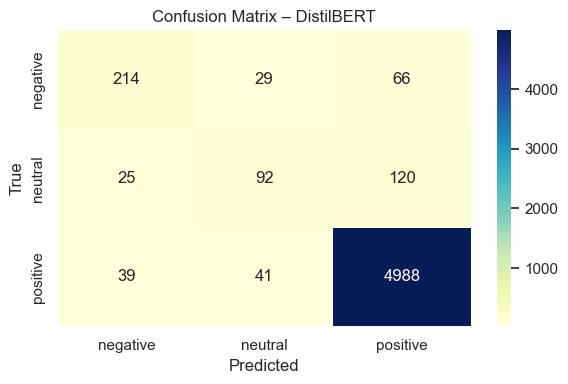

In [19]:
# Predict
predictions = trainer.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

# Classification report
print("📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=le.classes_, digits=4))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix – DistilBERT")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

### 🔍 Model Performance Comparison

| Model               | Accuracy | Macro F1 | Positive F1 | Neutral F1 | Negative F1 |
|---------------------|----------|----------|-------------|------------|-------------|
| TF-IDF + LogisticRegression | 86.5%   | 0.6438   | 0.9271      | 0.3764     | 0.6281      |
| 🤖 DistilBERT Fine-tuned     | **94.3%** | **0.7214** | **0.9740**  | **0.4612**  | **0.7291**  |

- **DistilBERT outperforms traditional models** across nearly all metrics.
- Particularly strong at identifying **positive** and **negative** reviews.
- **Neutral sentiment** remains more ambiguous, suggesting further fine-tuning or more data could help.

In [21]:
# Create export directory
import os
output_dir = "../models/bert_sentiment"
os.makedirs(output_dir, exist_ok=True)

# Save the model
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

print(f"✅ Model and tokenizer saved to {output_dir}")

✅ Model and tokenizer saved to ../models/bert_sentiment


## 9.2 Example

In [ ]:
# Load model and tokenizer
model_path = "./models/bert_sentiment"
model = DistilBertForSequenceClassification.from_pretrained(model_path)
tokenizer = DistilBertTokenizerFast.from_pretrained(model_path)

# Example prediction
def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=256)
    outputs = model(**inputs)
    pred = outputs.logits.argmax(dim=1).item()
    return le.inverse_transform([pred])[0]  # inverse of label encoding

# Usage example
sample_text = "This is the best product I’ve ever used!"
print("Predicted sentiment:", predict_sentiment(sample_text))